<a href="https://colab.research.google.com/github/zphilip/zphilip.github.io/blob/main/GPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GP learning by doing , Refer to 
https://peterroelants.github.io/posts/gaussian-process-kernels/
https://zhuanlan.zhihu.com/p/31427491

In [ ]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter("ignore")

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels # Positive-semidefinite kernels package, 也是对一切合法kernal的定义

sns.set_style('darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Plotting function to be used below

def plot_kernel(X, y, Σ, description, fig, subplot_spec, xlim,
                scatter=False, rotate_x_labels=False):
    """Plot kernel matrix and samples."""
    grid_spec = gridspec.GridSpecFromSubplotSpec(
        1, 2, width_ratios=[2,1], height_ratios=[1],
        wspace=0.18, hspace=0.0,
        subplot_spec=subplot_spec)
    ax1 = fig.add_subplot(grid_spec[0])
    ax2 = fig.add_subplot(grid_spec[1])
    # Plot samples
    if scatter:
        for i in range(y.shape[1]):
            ax1.scatter(X, y[:,i], alpha=0.8, s=3)
    else:
        for i in range(y.shape[1]):
            ax1.plot(X, y[:,i], alpha=0.8)
    ax1.set_ylabel('$y$', fontsize=13, labelpad=0)
    ax1.set_xlabel('$x$', fontsize=13, labelpad=0)
    ax1.set_xlim(xlim)
    if rotate_x_labels:
        for l in ax1.get_xticklabels():
            l.set_rotation(30)
    ax1.set_title(f'Samples from {description}')
    # Plot covariance matrix
    im = ax2.imshow(Σ, cmap=cm.YlGnBu)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.02)
    cbar = plt.colorbar(im, ax=ax2, cax=cax)
    cbar.ax.set_ylabel('$K(X,X)$', fontsize=8)
    ax2.set_title(f'Covariance matrix\n{description}')
    ax2.set_xlabel('X', fontsize=10, labelpad=0)
    ax2.set_ylabel('X', fontsize=10, labelpad=0)
    # Show 5 custom ticks on x an y axis of covariance plot
    nb_ticks = 5
    ticks = list(range(xlim[0], xlim[1]+1))
    ticks_idx = np.rint(np.linspace(
        1, len(ticks), num=min(nb_ticks,len(ticks)))-1).astype(int)
    ticks = list(np.array(ticks)[ticks_idx])
    ax2.set_xticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_yticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_xticklabels(ticks)
    ax2.set_yticklabels(ticks)
    if rotate_x_labels:
        for l in ax2.get_xticklabels():
            l.set_rotation(30)
    ax2.grid(False)
#

Kernel function
A kernel (or covariance function) describes the covariance of the Gaussian process random variables. Together with the mean function the kernel completely defines a Gaussian process.

The kernel function $k(x, x')$ models the covariance between each pair in $x$. The kernel function together with the mean function $m(x)$
 define the Gaussian process distribution:
 $$y \sim \mathcal{GP}(m(x),k(x,x'))$$

Valid kernels 

n order to be a valid kernel function the resulting kernel matrix $\Sigma = k(X, X)$
 should **be positive definite** . Which implies that the matrix should be **symmetric** . Being positive definite also means that the kernel matrix is invertible .

The process of defining a new valid kernel from scratch it not always trivial. Typically pre-defined kernels are used to model a variety of processes. In what follows we will visually explore some of these pre-defined kernels 


**Squared Exponential Kernel (Exponentiated quadratic kernel)**
The exponentiated quadratic kernel (also known as squared exponential kernel, Gaussian kernel or radial basis function kernel) is one of the most popular kernels used in Gaussian process modelling. It can be computed as:
$$k(x_a, x_b) = \sigma^2 \exp \left(-\frac{ \left\Vert x_a - x_b \right\Vert^2}{2\ell^2}\right)$$

With: 

*   $\sigma^2$the overall variance (\sigma 
 is also known as amplitude). it determines the average distance of your function away from its mean. Every kernel has this parameter out in front; it's just a scale factor.
*   $l$ the lengthscale.determines the length of the 'wiggles' in your function. In general, you won't be able to extrapolate more than ℓ
 units away from your data


Using the exponentiated quadratic kernel will result in a smooth prior on functions sampled from the Gaussian process.

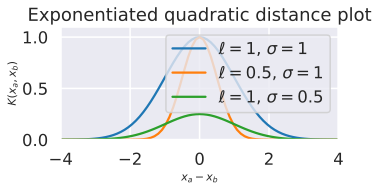

In [ ]:
# Plot exponentiated quadratic distance

xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=75), 1)
zero = np.array([[0.]])
# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3))

Σ = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=1.).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell = 1$, $\\sigma = 1$')
Σ = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=0.5).matrix(zero, X).numpy()
ax.plot(X[:,0], Σ[0,:], label='$\\ell = 0.5$, $\\sigma = 1$')
Σ =  tfk.ExponentiatedQuadratic(amplitude=0.5, length_scale=1.).matrix(zero, X).numpy()

ax.plot(X[:,0], Σ[0,:], label='$\\ell = 1$, $\\sigma = 0.5$')
ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Exponentiated quadratic distance plot')
ax.set_ylim([0, 1.1])
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()
#

高斯过程，从字面上分解，我们就可以看出他包含两部分
- 高斯，指的是高斯分布
- 过程，指的是随机过程
<center>
<img src="https://drive.google.com/uc?export=view&id=1Esepf22Yt32X7KFJCu_T4JJnewPm978c" alt="Encoder" width="600"/>
</center>
<caption><center><font color='purple'><b>Figure 1</b></font></center></caption>

首先当随机变量是1维的时候，我们称之为一维高斯分布，概率密度函数 $p(x)=N(μ,σ2)$当随机变量的维度上升到有限的 p 维的时候，就称之为高维高斯分布， $p(x)=N(μ,Σp×p)$. 而高斯过程则更进一步，他是一个定义在连续域上的无限多个高斯随机变量所组成的随机过程，换句话说，高斯过程是一个无限维的高斯分布

对于一个连续域 T （假设他是一个时间轴），如果我们在连续域上任选 n 个时刻： t1,t2,t3,...,tn∈T ，使得获得的一个 n 维向量 ${ξ_1,ξ_2,ξ_3,...,ξ_n}$ 都满足其是一个 n 维高斯分布，那么这个 ${ξ_t}$ 就是一个高斯过程

对于一个 p 维的高斯分布而言，决定他的分布是两个参数，一个是 p 维的均值向量 μp ，他反映了 p 维高斯分布中每一维随机变量的期望，另一个就是 p×p 的协方差矩阵 Σp×p ，他反映了高维分布中，每一维自身的方差，以及不同维度之间的协方差

定义在连续域 T 上的高斯过程其实也是一样，他是无限维的高斯分布，他同样需要描述每一个时间点 t 上的均值，但是这个时候就不能用向量了，因为是在连续域上的，维数是无限的，因此就应该定义成一个关于时刻 t 的函数： $m(t)$ 。

协方差矩阵也是同理，无限维的情况下就定义为一个核函数 $k(s,t)$ ，其中 s 和 t 表示任意两个时刻，核函数也称协方差函数。核函数是一个高斯过程的核心，他决定了高斯过程的性质，在研究和实践中，核函数有很多种不同的类型，他们对高斯过程的衡量方法也不尽相同，这里我们介绍和使用最为常见的一个核函数：径向基函数 RBF - Squared Exponential Kernel ，其定义如下
$$k(x_a, x_b) = \sigma^2 \exp \left(-\frac{ \left\Vert x_a - x_b \right\Vert^2}{2\ell^2}\right)$$

这里面的 σ 和 l 是径向基函数的超参数，使我们提前可以设置好的，例如我们可以让 σ=1 ， l=1 ，从这个式子中，我们可以解读出他的思想

和 t 表示高斯过程连续域上的两个不同的时间点， $||s−t||^2$ 是一个二范式，简单点说就是 s 和 t 之间的距离，径向基函数输出的是一个标量，他代表的就是 s 和 t 两个时间点各自所代表的高斯分布之间的协方差值，很明显径向基函数是一个关于s，t距离负相关的函数，两个点距离越大，两个分布之间的协方差值越小，即相关性越小，反之越靠近的两个时间点对应的分布其协方差值就越大。

由此，高斯过程的两个核心要素：均值函数和核函数的定义我们就描述清楚了，按照高斯过程存在性定理，一旦这两个要素确定了，那么整个高斯过程就确定了：
$$ξ_t∼GP(m(t),k(t,s))$$

In [ ]:
import numpy as np

def gaussian_kernel(x1, x2, l=1.0, sigma_f=1.0):
    m, n = x1.shape[0], x2.shape[0]
    dist_matrix = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = np.sum((x1[i] - x2[j]) ** 2)
    return sigma_f ** 2 * np.exp(- 0.5 / l ** 2 * dist_matrix)

train_X = np.array([1, 3, 7, 9]).reshape(-1, 1)#转换为4*1矩阵形式
print(gaussian_kernel(train_X, train_X))

[[1.00000000e+00 1.35335283e-01 1.52299797e-08 1.26641655e-14]
 [1.35335283e-01 1.00000000e+00 3.35462628e-04 1.52299797e-08]
 [1.52299797e-08 3.35462628e-04 1.00000000e+00 1.35335283e-01]
 [1.26641655e-14 1.52299797e-08 1.35335283e-01 1.00000000e+00]]




Generate the GP:
*   给定mean function和covariance（kernel） function，比如最简单的mean默认为constant，且为0，,kernel = Squared Exponential(SE)。
*   给定mean function以及kernel中的hyperparameter的初始值，比如，mean是constant，一点为0那就是处处为0了，kernel =SE, 需要给出其中的$\ell,\sigma^2$ (refer to Documentation for GPML Matlab Code)
*   给定想要产生的样本函数定义域，比如问题图中的范围[0,1]，如果是计算程序的，自然还涉及到取多少个点，比如在给定的[0,1]每隔0.01去一个点总共101个输入点。
*   有了mean function和kernel以及对应的初始超参数，那么我们就可以计算对应的mean function 的均值向量，记为M， kernel的covariance matrix，记为C。
*   对C进行SVD分解 $C=\mu sv^{'}$
*   从标准高斯分布中产生n个点的样本，这里n就是输入点的个数，记为$g_n$
*   利用$z_{gp}=\mu \sqrt{s}g_n+M$就可以生成一个给定具体mean function和kernel的GP的样本。

这个定理（详见https://arxiv.org/pdf/1605.07906.pdf）[3] 
<center>
<img src="https://drive.google.com/uc?export=view&id=1KgnxkwS6DGJhBE5_WtwycdwvRaD0XYIv" alt="Encoder" width="600"/>
</center>
<center>
<caption><font color='purple'><b>Figure 2</font></caption>
</center>

所以, 
$$
E\left(z_{g p}\right)=u \sqrt{s} E\left(g_n\right)+E(M)=M
$$
$$
\operatorname{cov}\left(z_{g p}, z_{g p}^{\prime}\right)=u \sqrt{s} * 1 * \sqrt{s} v^{\prime}=u s v^{\prime}=C
$$
因此就可以说明这就是以上GP的一个样本。

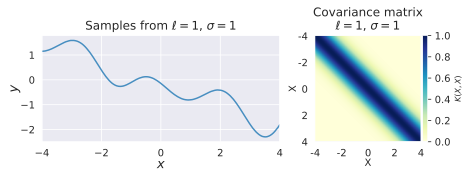

In [238]:
# Plot kernel matrix and samples of exponentiated quadratic

nb_of_samples = 150  # Number of test points.
nb_of_realizations = 1  # Number of function realizations
# Generate input points
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7, 10)) 
gs = gridspec.GridSpec(
    4, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
# 计算coveraince according to the input
Σ = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=1.).matrix(X, X).numpy()
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, '$\\ell = 1$, $\\sigma = 1$', 
    fig, gs[0], xlim)

In [ ]:
Σ

array([[1.0000000e+00, 9.9855906e-01, 9.9425161e-01, ..., 2.9727445e-14,
        1.9430919e-14, 1.2664165e-14],
       [9.9855906e-01, 1.0000000e+00, 9.9856001e-01, ..., 4.5349351e-14,
        2.9727502e-14, 1.9430919e-14],
       [9.9425161e-01, 9.9856001e-01, 1.0000000e+00, ..., 6.8981279e-14,
        4.5349351e-14, 2.9727445e-14],
       ...,
       [2.9727445e-14, 4.5349351e-14, 6.8981279e-14, ..., 1.0000000e+00,
        9.9856001e-01, 9.9425161e-01],
       [1.9430919e-14, 2.9727502e-14, 4.5349351e-14, ..., 9.9856001e-01,
        1.0000000e+00, 9.9855906e-01],
       [1.2664165e-14, 1.9430919e-14, 2.9727445e-14, ..., 9.9425161e-01,
        9.9855906e-01, 1.0000000e+00]], dtype=float32)

Example code how how to draw example from data, the data x , cacluate the covariacne matrix from kernel, assume we already know the mean value. 

In [239]:
def kernel(a, b):
 # Squared Exponential Kernel Function for GP
 square_distance = np.sum((a-b) ** 2)
 return np.exp(-0.5 * square_distance)

In [240]:
def draw_samples(mean,X,covariance, num_samples=1):
 # SVD gives better numerical stability than Cholesky Decomp 
 num_dimensions = len(X)
 z = np.random.standard_normal((num_dimensions,num_samples))
 [U, S, V] = np.linalg.svd(covariance)
 A = U * np.sqrt(S)
 all_samples = mean + np.dot(A, z)
 return all_samples

all_samples = draw_samples(2,X,Σ,10)

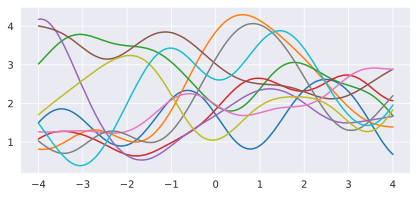

In [241]:
plt.figure(figsize=(7, 3))
plt.plot(X, all_samples)
plt.show()

**Here we only sample the random varibale from the prior, so you will see each sample will have the 0 mean and defined variance**

Example 1, Noise data

In [242]:
def kernel(x, y, l2=0.1):
  sqdist = np.sum(x**2,1).reshape(-1,1) + \
  	             np.sum(y**2,1) - 2*np.dot(x, y.T)
  return np.exp(-.5 * (1/l2) * sqdist)

def kernel_advance(X1, X2, l=1.0, sigma_f=1.0):
    ''' Isotropic squared exponential kernel. Computes a covariance matrix from points in X1 and X2. Args: X1: Array of m points (m x d). X2: Array of n points (n x d). Returns: Covariance matrix (m x n). '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)  

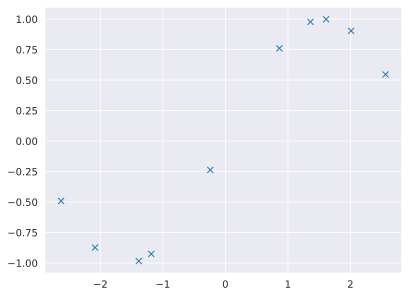

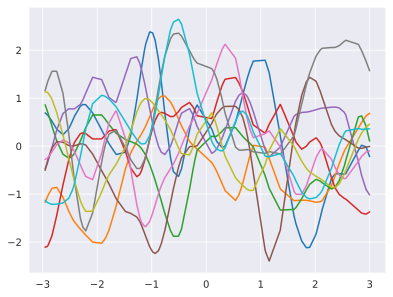

In [246]:
import numpy as np
def generate_noisy_points(n=10, noise_variance=1e-6):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y

import matplotlib.pylab as plt

noise_var = 1e-6
X, y = generate_noisy_points(n=10,noise_variance=noise_var)
plt.plot(X, y, 'x')
plt.show()

Xtest, ytest = generate_noisy_points(100,noise_variance=noise_var)
Xtest.sort(axis=0)

n_samples = 10
n = len(Xtest)
K_ss = kernel(Xtest,Xtest)
#L_ss = np.linalg.cholesky(K_ss)    #it could not be solved if becuase the K_ss is not positive matrix
L_ss = np.linalg.cholesky(K_ss + 1e-6*np.eye(n)) # has to add some small noise value
f_prior = np.dot(L_ss, np.random.normal(size=(n, n_samples)))  #draw samples

plt.plot(Xtest, f_prior)
plt.show()

In [230]:
K_ss.shape

()

Here we add the test data to comupte the posterior. Not anymore zero mean after posterior. compare to the 
$$
\mathbf{\mu}_{\mathbf{*}}\mathbf{= \ \mu}\left( \mathbf{X}_{\mathbf{*}} \right)\mathbf{+}\mathbf{K}_{\mathbf{*}}^{\mathbf{T}}\mathbf{K}^{\mathbf{- 1}}\mathbf{(f - \mu}\left( \mathbf{X} \right)\mathbf{)}\tag{15.8}
$$		
$$
\mathbf{\Sigma}_{\mathbf{*}}\mathbf{=}\mathbf{K}_{\mathbf{**\ }}\mathbf{-}\mathbf{K}_{\mathbf{*}}^{\mathbf{T}}\mathbf{K}^{\mathbf{- 1}}\mathbf{K}_{\mathbf{*}}\tag{15.9}
$$
and the algorithm 
\begin{aligned}
& \overline{f_*}=\mathbf{k}_*^T \mathbf{K}_y^{-1} \mathbf{y}\\
& \mathbf{K}_y=\mathbf{L L}^T \\
& \boldsymbol{\alpha}=\mathbf{K}_y^{-1} \mathbf{y}=\mathbf{L}^{-T} \mathbf{L}^{-1} \mathbf{y}
\end{aligned}
 
$$
\begin{array}{ll}
\hline \text { Algorithm 15.l: GP regression } \\
\hline 1 & \mathbf{L}=\text { cholesky }\left(\mathbf{K}+\sigma_y^2 \mathbf{I}\right) ; \\
2 & \boldsymbol{\alpha}=\mathbf{L}^T \backslash(\mathbf{L} \backslash \mathbf{y}) ; \\
3 & \mathbb{E}\left[f_*\right]=\mathbf{k}_*^T \boldsymbol{\alpha} ; \\
4 & \mathbf{v}=\mathbf{L} \backslash \mathbf{k}_* ; \\
5 & \operatorname{var}\left[f_*\right]=\kappa\left(\mathbf{x}_* \cdot \mathbf{x}_*\right)-\mathbf{v}^T \mathbf{v} ; \\
6 & \log p(\mathbf{y} \mid \mathbf{X})=-\frac{1}{2} \mathbf{y}^T \boldsymbol{\alpha}-\sum_i \log L_{i i}-\frac{N}{2} \log (2 \pi) \\
\hline
\end{array}
$$

In [ ]:
K = kernel(X, X)
L = np.linalg.cholesky(K)
m = np.linalg.solve(L, y)
alpha = np.linalg.solve(L.T, m)
K_s = kernel(X, Xtest)
mu = K_s.T @ alpha
K_ss = kernel(Xtest, Xtest) + 1e-8 * np.eye(len(Xtest)) #after adding 1e-8 * np.eye(len(Xtest)), the L_ss can be computed. so adding some very small number make the K_ss postive???
L_ss = np.linalg.cholesky(K_ss)  # this is always cannot be solved (Matrix is not positive definite), why?
beta = np.linalg.solve(K, K_s)
cov = K_ss - K_s.T @ beta
L_cov = np.linalg.cholesky(cov)
f_posterior = mu.reshape(-1, 1) + L_cov @ np.random.normal(size=(n,n_samples))

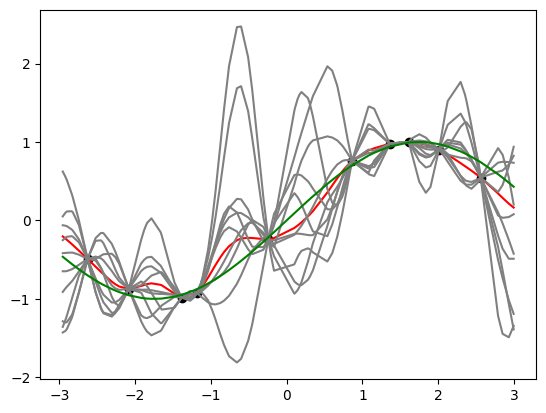

In [ ]:
plt.scatter(X, y, color="black")
plt.plot(Xtest, mu,color="red")
plt.plot(Xtest, f_posterior,color="gray")
plt.plot(Xtest, f(Xtest), color="green")
plt.show()

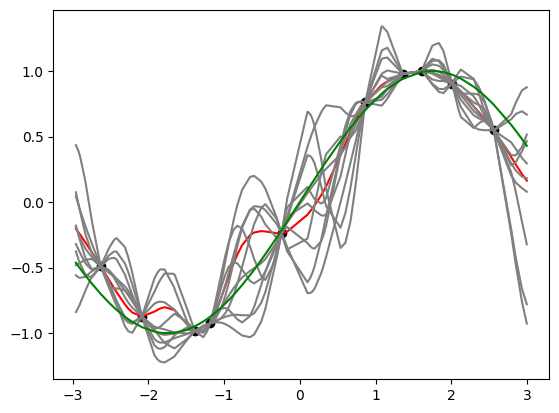

In [ ]:
from numpy.linalg import inv
from numpy.linalg import cholesky

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    ''' Computes the suffifient statistics of the GP posterior predictive distribution from m training data X_train and Y_train 
    and n new inputs X_s. Args: X_s: New input locations (n x d). X_train: Training locations (m x d). Y_train: Training targets (m x 1).
    l: Kernel length parameter. sigma_f: Kernel vertical variation parameter. sigma_y: Noise parameter. 
    Returns: Posterior mean vector (n x d) and covariance matrix (n x n). '''
    K = kernel_advance(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train)) #add the noise variance...sigma_y**2 * np.eye(len(X_train)
    K_s = kernel_advance(X_train, X_s, l, sigma_f)
    K_ss = kernel_advance(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    L_ss = np.linalg.cholesky(K_ss)
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    return mu_s, cov_s 

mu_s, cov_s = posterior_predictive(Xtest, X, y,l=(0.1**0.5), sigma_f=0.5)

L_cov = np.linalg.cholesky(cov_s)
f_posterior = mu.reshape(-1, 1) + L_cov @ np.random.normal(size=(n,n_samples))
f = lambda x: np.sin(0.9 * x)

plt.scatter(X, y, color="black")
plt.plot(Xtest, mu_s,color="red")
plt.plot(Xtest, f_posterior,color="gray")
plt.plot(Xtest, f(Xtest), color="green")
plt.show()

Different approach

\begin{aligned}
& \overline{f_*}=\mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y}\\
& \mathbf{K}_y=\mathbf{L L}^T \\
& \boldsymbol{LK}=\mathbf{K_*}_y \mathbf{L^{-1}}
\end{aligned}
 
$$
\begin{array}{ll}
\hline \text { Algorithm } \\
\hline 1 & \mathbf{L}=\text { cholesky }\left(\mathbf{K}+\sigma_y^2 \mathbf{I}\right) ; \\
2 & \boldsymbol{LK}=\mathbf{K_*}_y \mathbf{L^{-1}} ; \\
3 & \mathbb{E}\left[f_*\right]=(\boldsymbol{LK})^T \boldsymbol{yL^{-1}} = \frac{K_*^T}{L^T} \frac{y}{L} =K_*^TyK_y^{-1} ; \\
4 & \mathbf{v}=\mathbf{L} \backslash \mathbf{k}_* ;  \\
5 & \operatorname{var}\left[f_*\right]=\kappa\left(\mathbf{x}_* \cdot \mathbf{x}_*\right)-\mathbf{v}^T \mathbf{v} ; \\
6 & \log p(\mathbf{y} \mid \mathbf{X})=-\frac{1}{2} \mathbf{y}^T \boldsymbol{\alpha}-\sum_i \log L_{i i}-\frac{N}{2} \log (2 \pi) \\
\hline
\end{array}
$$

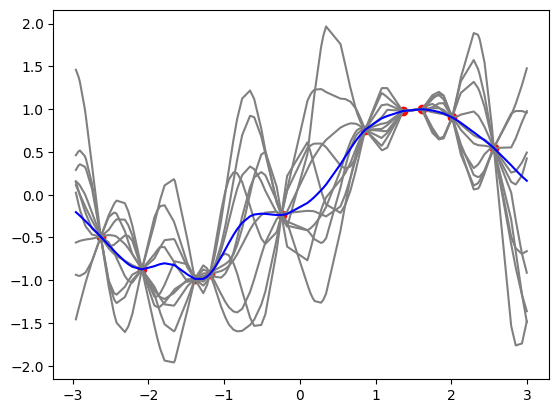

In [ ]:
N, n = len(X), len(Xtest)
K = kernel(X, X)
L = np.linalg.cholesky(K + noise_var*np.eye(N)) #add the noise variance...
K_ = kernel(Xtest, Xtest)           #k**
Lk = np.linalg.solve(L, kernel(X, Xtest))  #LK =k*/L
mu = np.dot(Lk.T, np.linalg.solve(L, y))   # (k*T y)/LLT
cov = K_ - np.dot(Lk.T, Lk)
L_cov = np.linalg.cholesky( cov + noise_var*np.eye(n))  #add the noise variance...
f_post = mu.reshape(-1,1) + np.dot(L_cov, np.random.normal(size=(n,n_samples)))

plt.scatter(X, y, color="red")
plt.plot(Xtest, f_post,color="gray")
plt.plot(Xtest, mu,color="blue" )
plt.show()

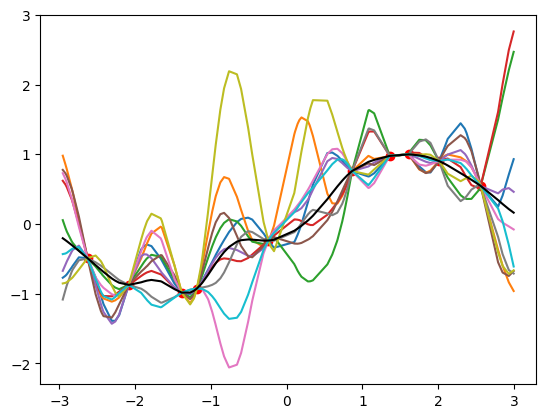

In [ ]:
def posterior(X, Xtest, l2=0.1, noise_var=1e-6,n_samples=1):
    # compute the mean at our test points.
    N, n = len(X), len(Xtest)
    K = kernel(X, X, l2) 
    L = np.linalg.cholesky(K + noise_var*np.eye(N)) #add the noise variance...
    Lk = np.linalg.solve(L, kernel(X, Xtest, l2))  #k*
    mu = np.dot(Lk.T, np.linalg.solve(L, y))
    # compute the variance at our test points.
    K_ = kernel(Xtest, Xtest, l2) #K**
    sd = np.sqrt(np.diag(K_) - np.sum(Lk**2, axis=0))
    L = np.linalg.cholesky(K_ + noise_var*np.eye(n) - np.dot(Lk.T, Lk)) #add the noise variance...
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,n_samples)))
    return (mu, sd, f_post)

mu, sd, f_post = posterior(X, Xtest, n_samples=n_samples)

plt.scatter(X, y, color="red")
plt.plot(Xtest, f_post)
plt.plot(Xtest, mu,color="black" )
plt.show()

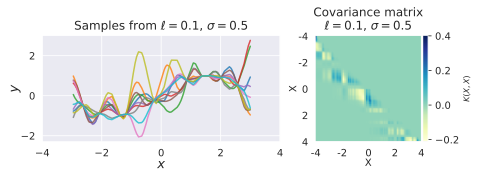

In [ ]:
xlim = (-4, 4)
# Start plotting
fig = plt.figure(figsize=(7, 10)) 
gs = gridspec.GridSpec(
    4, 1, figure=fig, wspace=0.2, hspace=0.4)
plot_kernel(
    Xtest, f_post, L_cov, '$\\ell = 0.1$, $\\sigma = 0.5$', 
    fig, gs[0], xlim)